# NLP - Assignment 2

## Imports

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from FuzzyTM import FLSA_W
import matplotlib.pyplot as plt

c:\Users\bravo\anaconda3\envs\JADS-NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess Data

In [2]:
path = "./us_equities_news_dataset.csv"

# Load the news dataset
news_dataset = pd.read_csv("./us_equities_news_dataset.csv")
news_dataset.head()

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,Why Shares of Chinese Electric Car Maker NIO A...,news,What s happening\nShares of Chinese electric c...,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327
1,221516,NIO,NIO only consumer gainer Workhorse Group amon...,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,Seeking Alpha,https://invst.ly/pje9c,2062196
2,221517,NIO,NIO leads consumer gainers Beyond Meat and Ma...,news,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,Seeking Alpha,https://invst.ly/pifmv,2060249
3,221518,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,Seeking Alpha,https://invst.ly/picu8,2060039
4,221519,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,Seeking Alpha,https://seekingalpha.com/news/3529772-plug-nio...,2053096


In [3]:
# Filter dataset to only include articles with 'Nvidia' in the content
nvidia_dataset = news_dataset[news_dataset['content'].str.contains('Nvidia', case=False, na=False)]


In [4]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text, 
                    remove_punctuation=True, 
                    remove_stopwords=True, 
                    lemmatize=False, 
                    stem=False, 
                    remove_short_words=False, 
                    remove_rare_words=False, 
                    remove_numbers=True, 
                    min_word_length=2):
    """
    Advanced preprocessing function that applies different levels of text processing.
    
    Parameters:
    - text: The text to preprocess.
    - remove_punctuation: Whether to remove punctuation from the text.
    - remove_stopwords: Whether to remove common stopwords.
    - lemmatize: Whether to apply lemmatization to reduce words to their root form.
    - stem: Whether to apply stemming to reduce words to their base form.
    - remove_short_words: Whether to remove short words from the text.
    - remove_rare_words: Whether to remove rare words based on the dataset distribution.
    - remove_numbers: Whether to remove numbers from the text.
    - min_word_length: The minimum length of words to keep in the text.
    
    Returns:
    - Preprocessed text as tokens.
    """
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    
    # Remove numbers if specified
    if remove_numbers:
        tokens = [re.sub(r'\d+', '', token) for token in tokens]
    
    # Remove non-alphabetic characters (punctuation)
    if remove_punctuation:
        tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    
    # Remove stopwords
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Stemming (alternative to lemmatization)
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]
    
    # Remove short words
    if remove_short_words:
        tokens = [token for token in tokens if len(token) >= min_word_length]
    
    return tokens

In [5]:
# Concatenate title and content columns
nvidia_dataset['content'] = nvidia_dataset['title'] + ' ' + nvidia_dataset['content']

In [6]:
def apply_preprocessing(nvidia_dataset, version='v1'):
    """
    Apply different levels of preprocessing to the dataset.
    
    Parameters:
    - nvidia_dataset: The Nvidia articles with a 'content' column.
    - version: The version of preprocessing to apply ('v1', 'v2', 'v3', or 'v4').
    
    Returns:
    - DataFrame with the original content and the preprocessed content in 'preprocessed_content' column.
    """
    
    if version == 'v1':
        # Basic tokenization and lowercasing
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=False, remove_stopwords=False, 
            lemmatize=False, remove_numbers=False, stem=False, 
            remove_short_words=False
        ))
    
    elif version == 'v2':
        # Remove punctuation, stopwords, and numbers, but no lemmatization/stemming
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=True, remove_stopwords=True, 
            lemmatize=False, remove_numbers=False, stem=False, 
            remove_short_words=False
        ))
    
    elif version == 'v3':
        # Advanced preprocessing with stemming, number removal, short words removal
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=True, remove_stopwords=True, 
            lemmatize=False, stem=True, remove_numbers=True, 
            remove_short_words=True, min_word_length=2
        ))
    
    elif version == 'v4':
        # Full preprocessing with lemmatization instead of stemming, number removal, and short words removal
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=True, remove_stopwords=True, 
            lemmatize=True, remove_numbers=True, stem=False, 
            remove_short_words=True, min_word_length=2
        ))
    
    else:
        raise ValueError("Invalid preprocessing version. Choose from 'v1', 'v2', 'v3', or 'v4'.")
    
    # Return the DataFrame with original and preprocessed content
    return nvidia_dataset


In [7]:
train_data_v1 = apply_preprocessing(nvidia_dataset, version='v1')  # Basic preprocessing
train_data_v2 = apply_preprocessing(nvidia_dataset, version='v2')  # Intermediate preprocessing
train_data_v3 = apply_preprocessing(nvidia_dataset, version='v3')  # Full preprocessing with stemming
train_data_v4 = apply_preprocessing(nvidia_dataset, version='v4')  # Full preprocessing with lemmatizer

In [8]:
# train_data_head = train_data_v1.head()

# # Specify the filename for the Excel file
# output_file = 'train_data_v1_head.xlsx'

# # Save to Excel
# train_data_head.to_excel(output_file, index=False)

## Train Topic Models

In [9]:
def train_topic_model(train_data, model_type='LDA', num_topics=10):
    """
    Train a topic model on the given training data.

    Parameters:
    - train_data: list of str, the text to train the model on
    - model_type: str, the type of model to train ('LDA', 'FLSA-W', 'BERTopic')
    - num_topics: int, the number of topics to generate

    Returns:
    - model: the trained model
    - topics: the topics generated by the model
    """
    
    # Preprocessed content (tokenized) is passed to all models consistently
    train_data_list = [' '.join(tokens) for tokens in train_data['preprocessed_content']]

    if model_type == 'LDA':
        vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
        data_vectorized = vectorizer.fit_transform(train_data_list)
        
        # Train LDA model
        lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda_model.fit(data_vectorized)
        
        # Get topics (top words in each topic)
        def get_lda_topics(model, vectorizer, n_top_words=10):
            feature_names = vectorizer.get_feature_names_out()
            topics = []
            for topic_idx, topic in enumerate(model.components_):
                top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
                topics.append(top_words)
            return topics
        
        topics = get_lda_topics(lda_model, vectorizer)
        
        return lda_model, topics
    
    elif model_type == 'FLSA-W':
        # Tokenized input is passed directly to FLSA-W
        tokenized_data = [tokens for tokens in train_data['preprocessed_content']]

        # Initialize FLSA-W model with tokenized data directly
        flsa_w_model = FLSA_W(
            input_file=tokenized_data,  
            num_topics=num_topics,      
            num_words=10                
        )
        
        # Train the FLSA-W model
        pwgt, ptgd = flsa_w_model.get_matrices()  # This trains the model

        # Get topics as words
        topics = flsa_w_model.show_topics(representation='words')

        return flsa_w_model, topics
    
    elif model_type == 'BERTopic':
        # Train BERTopic model
        topic_model = BERTopic(nr_topics=num_topics)
        topics, _ = topic_model.fit_transform(train_data_list)
        
        return topic_model, topics
    
    else:
        raise ValueError("Invalid model_type. Choose from 'LDA', 'FLSA-W', 'BERTopic'.")

## Iteration 1

In [10]:
def print_topics_lda(topics):
    for idx, topic in enumerate(topics):
        print(f"Topic {idx + 1}: {', '.join(topic)}")

In [11]:
def print_bertopic_topics(topic_model):
    """
    Print topics generated by BERTopic.
    
    Parameters:
    - topic_model: the trained BERTopic model
    """
    topics = topic_model.get_topics()
    for topic_num, words in topics.items():
        # Ignore the '-1' topic, which is typically noise in BERTopic
        if topic_num == -1:
            continue
        print(f"Topic {topic_num}: {', '.join([word[0] for word in words])}")


### LDA

In [12]:
# Train LDA model on the first version of the preprocessed dataset
LDA__model, LDA_topics = train_topic_model(train_data_v1, model_type='LDA', num_topics=10)


In [13]:
# Print the generated LDA topics
print("Initial LDA Topics:")
print_topics_lda(LDA_topics)

Initial LDA Topics:
Topic 1: percent, year, market, share, price, week, data, said, analyst, investor
Topic 2: apple, company, china, google, said, iphone, service, technology, amazon, billion
Topic 3: nasdaq, nyse, stock, trade, point, index, share, china, dow, oil
Topic 4: stock, zacks, nasdaq, etf, fund, market, company, investor, investment, year
Topic 5: earnings, stock, zacks, year, company, estimate, growth, industry, share, revenue
Topic 6: year, quarter, company, zacks, revenue, million, earnings, stock, growth, billion
Topic 7: stock, market, nasdaq, week, day, trading, like, time, nyse, high
Topic 8: amd, gaming, intel, graphic, nasdaq, market, year, gpu, chip, gpus
Topic 9: company, new, facebook, nasdaq, amazon, microsoft, user, technology, ai, cloud
Topic 10: company, technology, driving, car, chip, vehicle, self, nasdaq, intel, market


### FLSA-W

In [14]:
# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics = train_topic_model(train_data_v1, model_type='FLSA-W', num_topics=10)


In [15]:
# Print the generated FLSA-W topics
print("Initial FLSA-W Topics:")
print_topics_lda(flsa_w_topics)

Initial FLSA-W Topics:
Topic 1: book, evolution, certainty, richard, synthesis, professor, creativity, feynman, inventing, pretend
Topic 2: newest, art, becoming, restriction, doubt, persist, editing, charles, tied, connecting
Topic 3: premarket, noel, randewich, divide, kem, pct, colette, qrvo, vlkay, staged
Topic 4: settle, implied, unveils, roku, thomson, swks, troy, nv, mellanox, subscribe
Topic 5: gmt, performer, towards, miner, incorporated, vector, citigroup, alllast, poured, rock
Topic 6: cryptocurrency, percent, matras, genius, witnessing, breaking, remarkable, previously, apart, marijuana
Topic 7: supervisory, whileolympusshares, upnoteus, delisting, icera, marketpulse, bofaml, trv, equitiesasian, chee
Topic 8: chipmaker, hottest, composite, rose, phenomenon, reuters, session, bell, jones, spotlight
Topic 9: nvda, nvidia, nyse, hold, best, recent, likely, day, top, zacks
Topic 10: broader, corporation, com, intc, rise, giant, industrial, led, fall, chip


In [16]:
def compute_coherence_flsa_w(train_data, max_topics=10):
    """
    Compute coherence scores for FLSA-W model with varying number of topics.
    Parameters:
        - train_data: list of tokenized documents (preprocessed content).
        - max_topics: int, the maximum number of topics to test.
    Returns:
        - topic_nums: list of topic numbers used for testing.
        - coherence_scores: list of coherence scores for each number of topics.
    """
    
    tokenized_data = [tokens for tokens in train_data['preprocessed_content']]
    
    topic_nums = []
    coherence_scores = []
    
    # Try different numbers of topics
    for num_topics in range(3, max_topics + 1):
        # Train FLSA-W model
        flsa_w_model = FLSA_W(
            input_file=tokenized_data,  
            num_topics=num_topics,      
            num_words=10                
        )
        
        # Train the FLSA-W model
        flsa_w_model.get_matrices()  
        
        # Get the coherence score for the current model
        coherence_score = flsa_w_model.get_coherence_score() 
        print(f"Number of topics: {num_topics}, Coherence score: {coherence_score}")
        
        # Store the results
        topic_nums.append(num_topics)
        coherence_scores.append(coherence_score)
    
    return topic_nums, coherence_scores


def plot_elbow_curve(topic_nums, coherence_scores):
    """
    Create an elbow plot for the coherence scores vs. number of topics.

    Parameters:
    - topic_nums: list of number of topics tested.
    - coherence_scores: list of coherence scores for each number of topics.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(topic_nums, coherence_scores, marker='o')
    plt.title('FLSA-W Elbow Plot: Number of Topics vs Coherence Score')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.show()

In [17]:
# Train the model and compute coherence scores
topic_nums, coherence_scores = compute_coherence_flsa_w(train_data_v1, max_topics=15)

Number of topics: 3, Coherence score: 0.39215558891255675
Number of topics: 4, Coherence score: 0.39411504947830545
Number of topics: 5, Coherence score: 0.4523960619322053
Number of topics: 6, Coherence score: 0.4113500987177594
Number of topics: 7, Coherence score: 0.4165684791647775
Number of topics: 8, Coherence score: 0.3848790394357928
Number of topics: 9, Coherence score: 0.3769917307957381
Number of topics: 10, Coherence score: 0.4192631097261835
Number of topics: 11, Coherence score: 0.3968726270089041
Number of topics: 12, Coherence score: 0.3838636933207795
Number of topics: 13, Coherence score: 0.37515545511281145
Number of topics: 14, Coherence score: 0.37403191644841904
Number of topics: 15, Coherence score: 0.3882115675564781


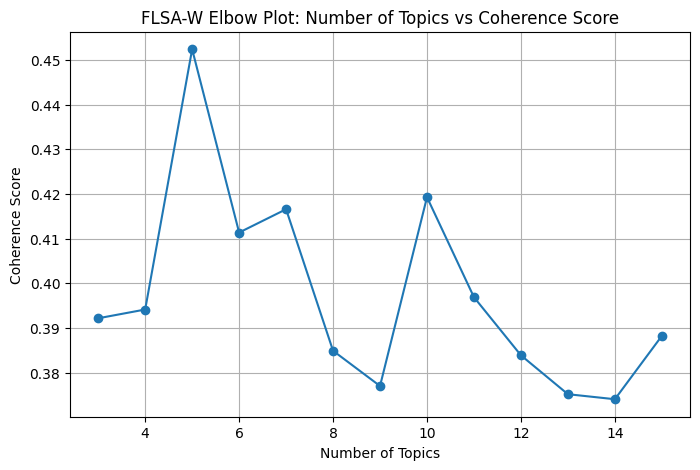

In [18]:
# Plot the elbow curve
plot_elbow_curve(topic_nums, coherence_scores)

### BERTopic

In [19]:
# Train BERTopic model on the first version of the preprocessed dataset
bertopic_model, bertopic_topics = train_topic_model(train_data_v1, model_type='BERTopic', num_topics=10)


In [20]:
# Print the generated BERTopic topics
print("BERTopic Topics:")
print_bertopic_topics(bertopic_model)

BERTopic Topics:
Topic 0: stock, nasdaq, year, company, zacks, earnings, quarter, market, share, revenue
Topic 1: nvidia, amd, year, revenue, gaming, quarter, company, share, gpu, graphic
Topic 2: traded, nvidia, day, seven, lowest, gmt, highest, exchange, volume, session
Topic 3: driving, car, vehicle, self, autonomous, company, technology, tesla, nvidia, said
Topic 4: scenario, oil, target, dollar, pivot, resistance, extension, comment, rsi, support
Topic 5: game, gaming, video, service, stadium, esports, company, google, nasdaq, streaming
Topic 6: facebook, user, ad, company, platform, video, twitter, snap, zacks, rank
Topic 7: earnings, growth, estimate, period, eps, company, index, revenue, year, zacks
Topic 8: qualcomm, patent, commission, eu, said, antitrust, google, european, fine, court


## Iteration 2

## Iteration 3

## Iteration ....

## Evaluation

### Qualitative

### Quantitative

## Output of Final Topic Model